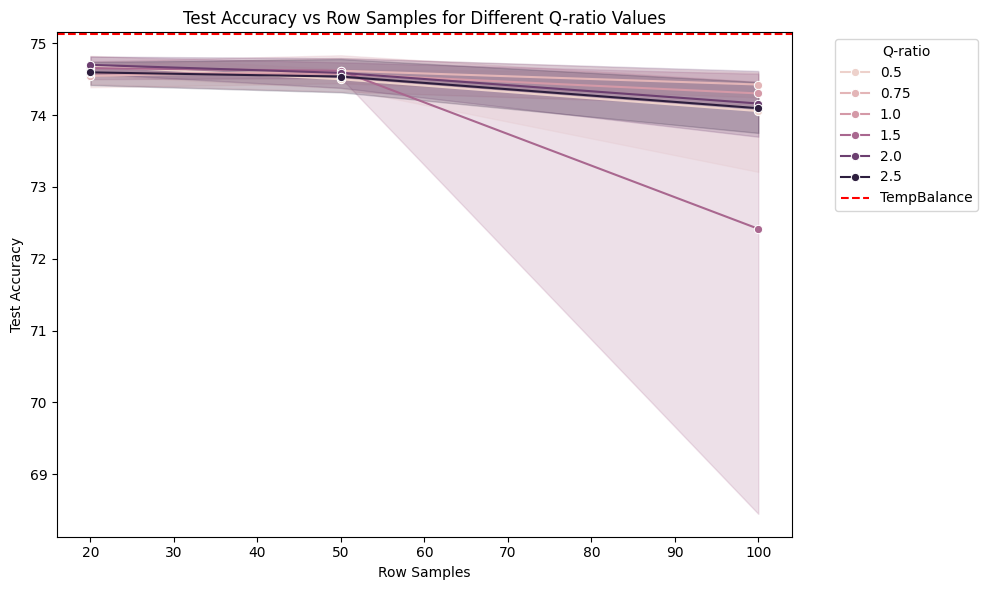

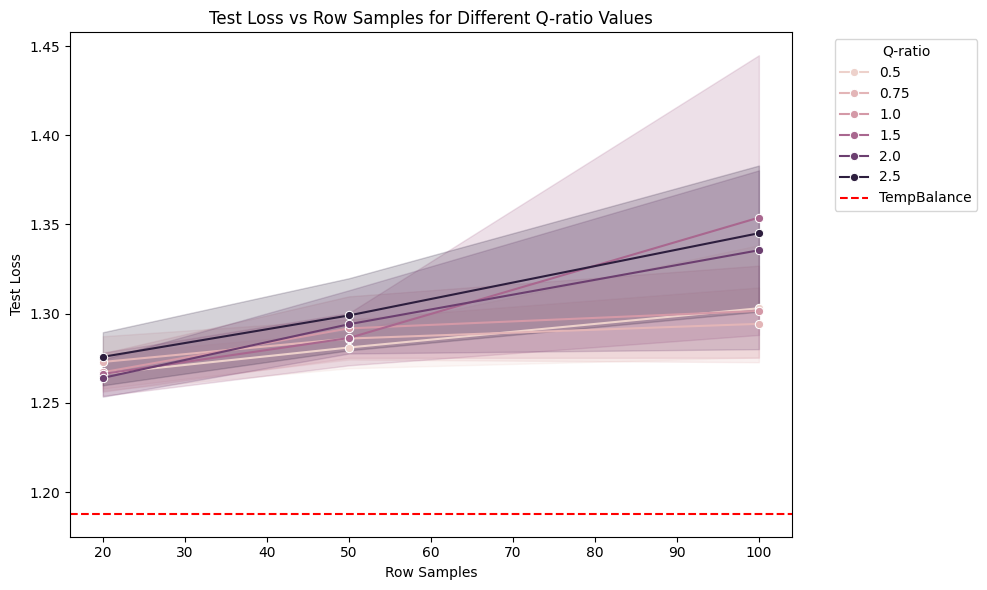

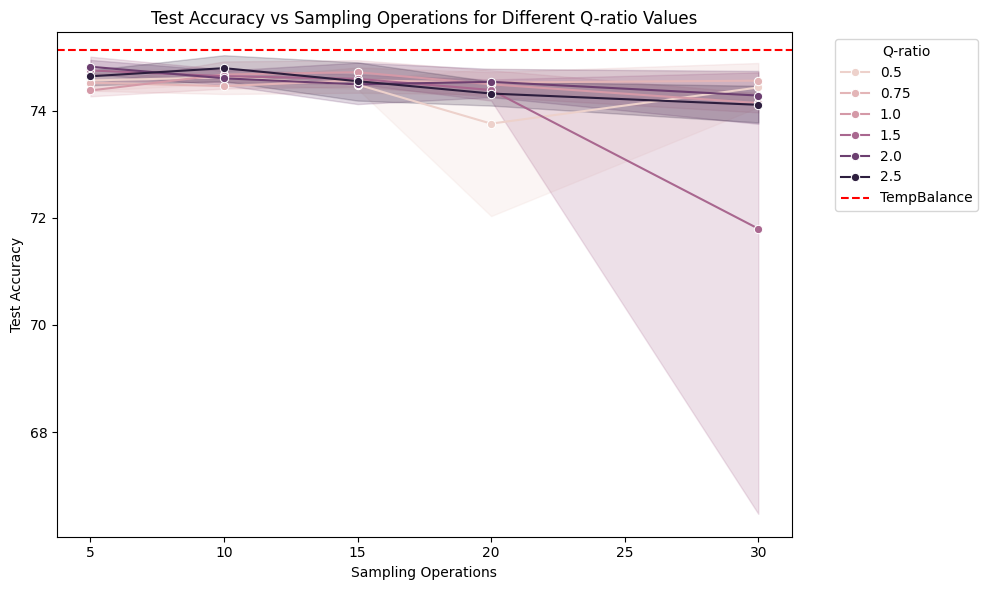

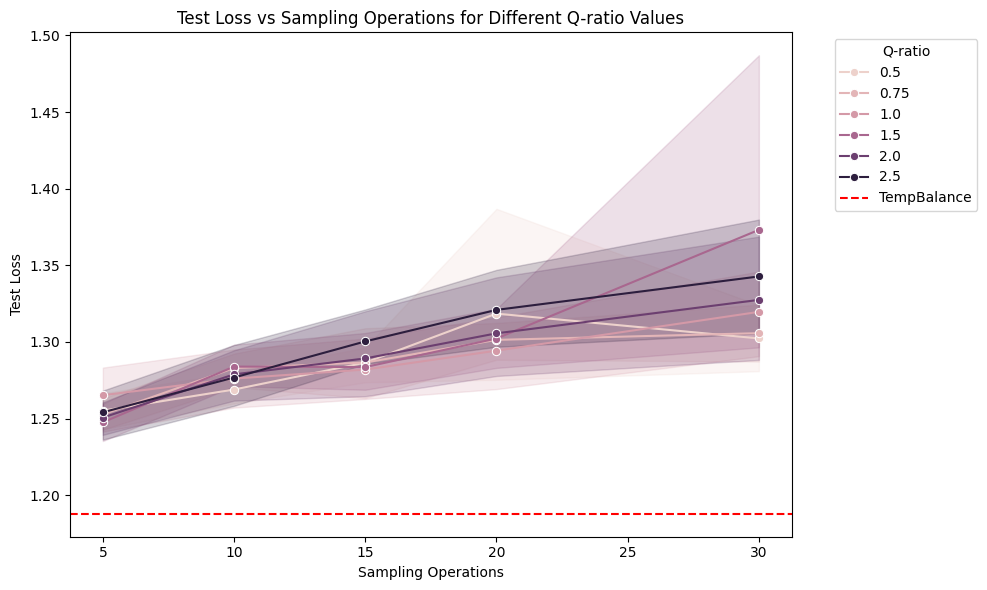

In [1]:
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

beginning = -20

# Hyperparameters
row_list = [20, 50, 100, 150, 200]
# row_list = [50]
qr_list = [0.5, 0.75, 1.0, 1.5, 2.0, 2.5]
ops_list = [5, 10, 15, 20, 30]
# ops_list = [20]
seed_list = [42, 43, 44]
# seed_list = [43]

dataset = 'cifar100'
model = 'vgg_cifar'
# model = 'resnet'
depth = 16
# depth = 18
slide_window = True  # Modify this based on your experiment configuration
cachedir = "/scratch/kinshuk/cache"

# Initialize a grid for all combinations of hyperparameters
grid = itertools.product(seed_list, row_list, qr_list, ops_list)

# Store results for each combination
results = []

# Load the baseline results for the specific directory path
baseline_results = []

for seed in seed_list:
    baseline_save_path = f"/jumbo/yaoqingyang/kinshuk/TempBalance/results/flatten/{seed}/{model}{depth}/{dataset}/slide_False"
    baseline_stats_path = os.path.join(baseline_save_path, f'training_stats.npy')
    if os.path.exists(baseline_stats_path) and os.path.getsize(baseline_stats_path) > 0:
        try:
            baseline_stats = np.load(baseline_stats_path, allow_pickle=True).item()
            baseline_test_loss = baseline_stats['test_loss'][beginning:]  # Use all epochs
            baseline_test_acc = baseline_stats['test_acc'][beginning:]    # Use all epochs
            baseline_results.append((seed, np.mean(baseline_test_loss), np.mean(baseline_test_acc)))
        except Exception as e:
            print(f"Error loading baseline file {baseline_stats_path}: {e}")
    else:
        continue
        print(f"Warning: Baseline file {baseline_stats_path} is empty or does not exist.")

# Calculate the average baseline result across all seeds
baseline_test_loss_avg = np.mean([entry[1] for entry in baseline_results])
baseline_test_acc_avg = np.mean([entry[2] for entry in baseline_results])

# Load the experimental results from the grid
for seed, row_samples, q_ratio, sampling_ops in grid:
    save_path = f"/jumbo/yaoqingyang/kinshuk/TempBalance/results/flatten/{seed}/{model}{depth}/{dataset}/slide_{slide_window}/row_{row_samples}/qr_{q_ratio}/ops_{sampling_ops}"
    stats_path = os.path.join(save_path, 'training_stats.npy')

    if os.path.exists(stats_path) and os.path.getsize(stats_path) > 0:
        # Load the training stats file
        try:
            stats = np.load(stats_path, allow_pickle=True).item()
            test_loss = stats['test_loss'][beginning:]  # Use all epochs
            test_acc = stats['test_acc'][beginning:]    # Use all epochs

            results.append((seed, row_samples, q_ratio, sampling_ops, np.mean(test_loss), np.mean(test_acc)))
        except Exception as e:
            print(f"Error loading file {stats_path}: {e}")
    else:
        continue
        print(f"Warning: {stats_path} is empty or does not exist.")

# Convert results to a numpy array for easier handling
results = np.array(results)

# Create a DataFrame to organize results (optional but makes plotting easier)
df = pd.DataFrame(results, columns=['seed', 'row_samples', 'q_ratio', 'sampling_ops', 'test_loss', 'test_acc'])

# Average results across seeds for each combination of hyperparameters
df_avg = df.groupby(['seed', 'row_samples', 'q_ratio', 'sampling_ops']).agg({
    'test_loss': 'mean',
    'test_acc': 'mean',
}).reset_index()

# Plotting the results using seaborn

# Test Accuracy vs Row Samples for different Q-ratio values including baseline
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, x='row_samples', y='test_acc', hue='q_ratio', marker='o')
plt.axhline(baseline_test_acc_avg, color='red', linestyle='--', label='TempBalance')  # Baseline as straight line
plt.title('Test Accuracy vs Row Samples for Different Q-ratio Values')
plt.xlabel('Row Samples')
plt.ylabel('Test Accuracy')
plt.legend(title='Q-ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Test Loss vs Row Samples for different Q-ratio values including baseline
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, x='row_samples', y='test_loss', hue='q_ratio', marker='o')
plt.axhline(baseline_test_loss_avg, color='red', linestyle='--', label='TempBalance')  # Baseline as straight line
plt.title('Test Loss vs Row Samples for Different Q-ratio Values')
plt.xlabel('Row Samples')
plt.ylabel('Test Loss')
plt.legend(title='Q-ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Test Accuracy vs Sampling Operations for different Q-ratio values including baseline
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, x='sampling_ops', y='test_acc', hue='q_ratio', marker='o')
plt.axhline(baseline_test_acc_avg, color='red', linestyle='--', label='TempBalance')  # Baseline as straight line
plt.title('Test Accuracy vs Sampling Operations for Different Q-ratio Values')
plt.xlabel('Sampling Operations')
plt.ylabel('Test Accuracy')
plt.legend(title='Q-ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Test Loss vs Sampling Operations for different Q-ratio values including baseline
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, x='sampling_ops', y='test_loss', hue='q_ratio', marker='o')
plt.axhline(baseline_test_loss_avg, color='red', linestyle='--', label='TempBalance')  # Baseline as straight line
plt.title('Test Loss vs Sampling Operations for Different Q-ratio Values')
plt.xlabel('Sampling Operations')
plt.ylabel('Test Loss')
plt.legend(title='Q-ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
